In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from datetime import date
import math
import pandas_datareader as web
import yfinance as yf
import time  # Import the time module
import os  # Import the os module
from sklearn.model_selection import TimeSeriesSplit

In [78]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from pathlib import Path

# Parameters

In [79]:
win_size = 100
num_epoch = 150
num_cell = 100
batch_size = 10
dropout = 0.2
split_date = '2020-12-31'
# pour stocker les modèles 
results_path = Path('models', 'Best')
if not results_path.exists():
    results_path.mkdir(parents=True)

In [80]:
# reshape 2D dataset (samples + features) en 3D (samples/time step + features + séquence) 
# en ajoutant la dimension fenêtre/séquence (longueur est window_size) N, pour prédire N+1. 
# y_pos est la position de colonnes du target. Normalament la prémière colonne
# dataset.shape[0] est le nombre des échantillons
def rnn_3D_data(dataset, window_size, y_pos=0): 
    X = []
    y = []
    for i in range(window_size, dataset.shape[0]):
        X.append(dataset[i-window_size: i])
        y.append(dataset[i, y_pos])
    X, y = np.array(X), np.array(y)
    return X, y

In [81]:
def data_retrieve(stock, start_date, end_date): 

# Define the list of tickers for the stocks you want to fetch data for
    tickers = [stock]

    # Define the list of stock indices and other features
    indices = ['^GSPC', '^DJI', '^IXIC', 'DX-Y.NYB', '^GDAXI', '^FTSE', '^N225', '^VIX']
    commodities = ['GC=F', 'BZ=F']
    forex = ['EURUSD=X', 'JPY=X']

    symbols = indices + commodities + forex
    # Fetch the historical data using yfinance for tickers (OHLC and Volume)
    ticker_data = yf.download(tickers, start=start_date, end=end_date)

    # Fetch the historical data using yfinance for indices and commodities (Close Price)
    close_data = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Concatenate the close_data with the ticker_data to include Close Price for all symbols
    all_data = pd.concat([ticker_data, close_data], axis=1)

# Print the data
    return all_data

In [82]:
# Définir le modèle avec cycle scaling, reshing, compile, entrainement
def LSTM_M0(df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout):

    scalar = MinMaxScaler()

    data_training_scaled = scalar.fit_transform(data_training)
    X_train, y_train = rnn_3D_data(data_training_scaled, window_size=win_size, y_pos=4)
    
    # add the winodw before test data
    data_test = pd.concat([data_training.tail(win_size), data_testing], ignore_index=True)
    data_test_scaled = scalar.fit_transform(data_test)
    X_test, y_test = rnn_3D_data(data_test_scaled, window_size=win_size, y_pos=4)
    
    y_scaler_train = MinMaxScaler()
    y_scaler_train.fit(data_training["Close"].values.reshape(-1, 1))
    y_scaler_test = MinMaxScaler()
    y_scaler_test.fit(data_test["Close"].values.reshape(-1, 1))
    
    model = Sequential()

    model.add(LSTM(units = num_cell, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units = 1, activation = 'sigmoid'))

    start_time = time.time()
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    
    rnn_path = (results_path / 'lstm_M0.h5').as_posix()
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)
    
    lstm_training = model.fit(X_train, y_train, epochs=num_epoch, batch_size = batch_size,\
                        shuffle=True, validation_data=(X_test, y_test),\
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)     
    
    end_time = time.time()
    execution_time = end_time - start_time   
    
    # evaluer le modèle
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(lstm_training.history).pow(.5)
    loss_history.index += 1
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    
    resultat = ['M0',win_size,num_cell, num_epoch, batch_size, dropout, round(best_rmse, 4), round(execution_time, 0)]
    return model, resultat, lstm_training, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test

# 1. Raw data collection

In [83]:
start_date = datetime.datetime(2010, 1, 2)
end_date = datetime.datetime.today()

In [84]:
raw_data = yf.download('^GSPC', start=start_date, end=end_date)
raw_data.to_parquet('sp500_data.parquet')

[*********************100%***********************]  1 of 1 completed


In [85]:
raw_data.to_parquet('sp500_data.parquet')

In [86]:
data = pd.read_parquet('sp500_data.parquet')

In [87]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [88]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))

There are 3430 number of days in the dataset.


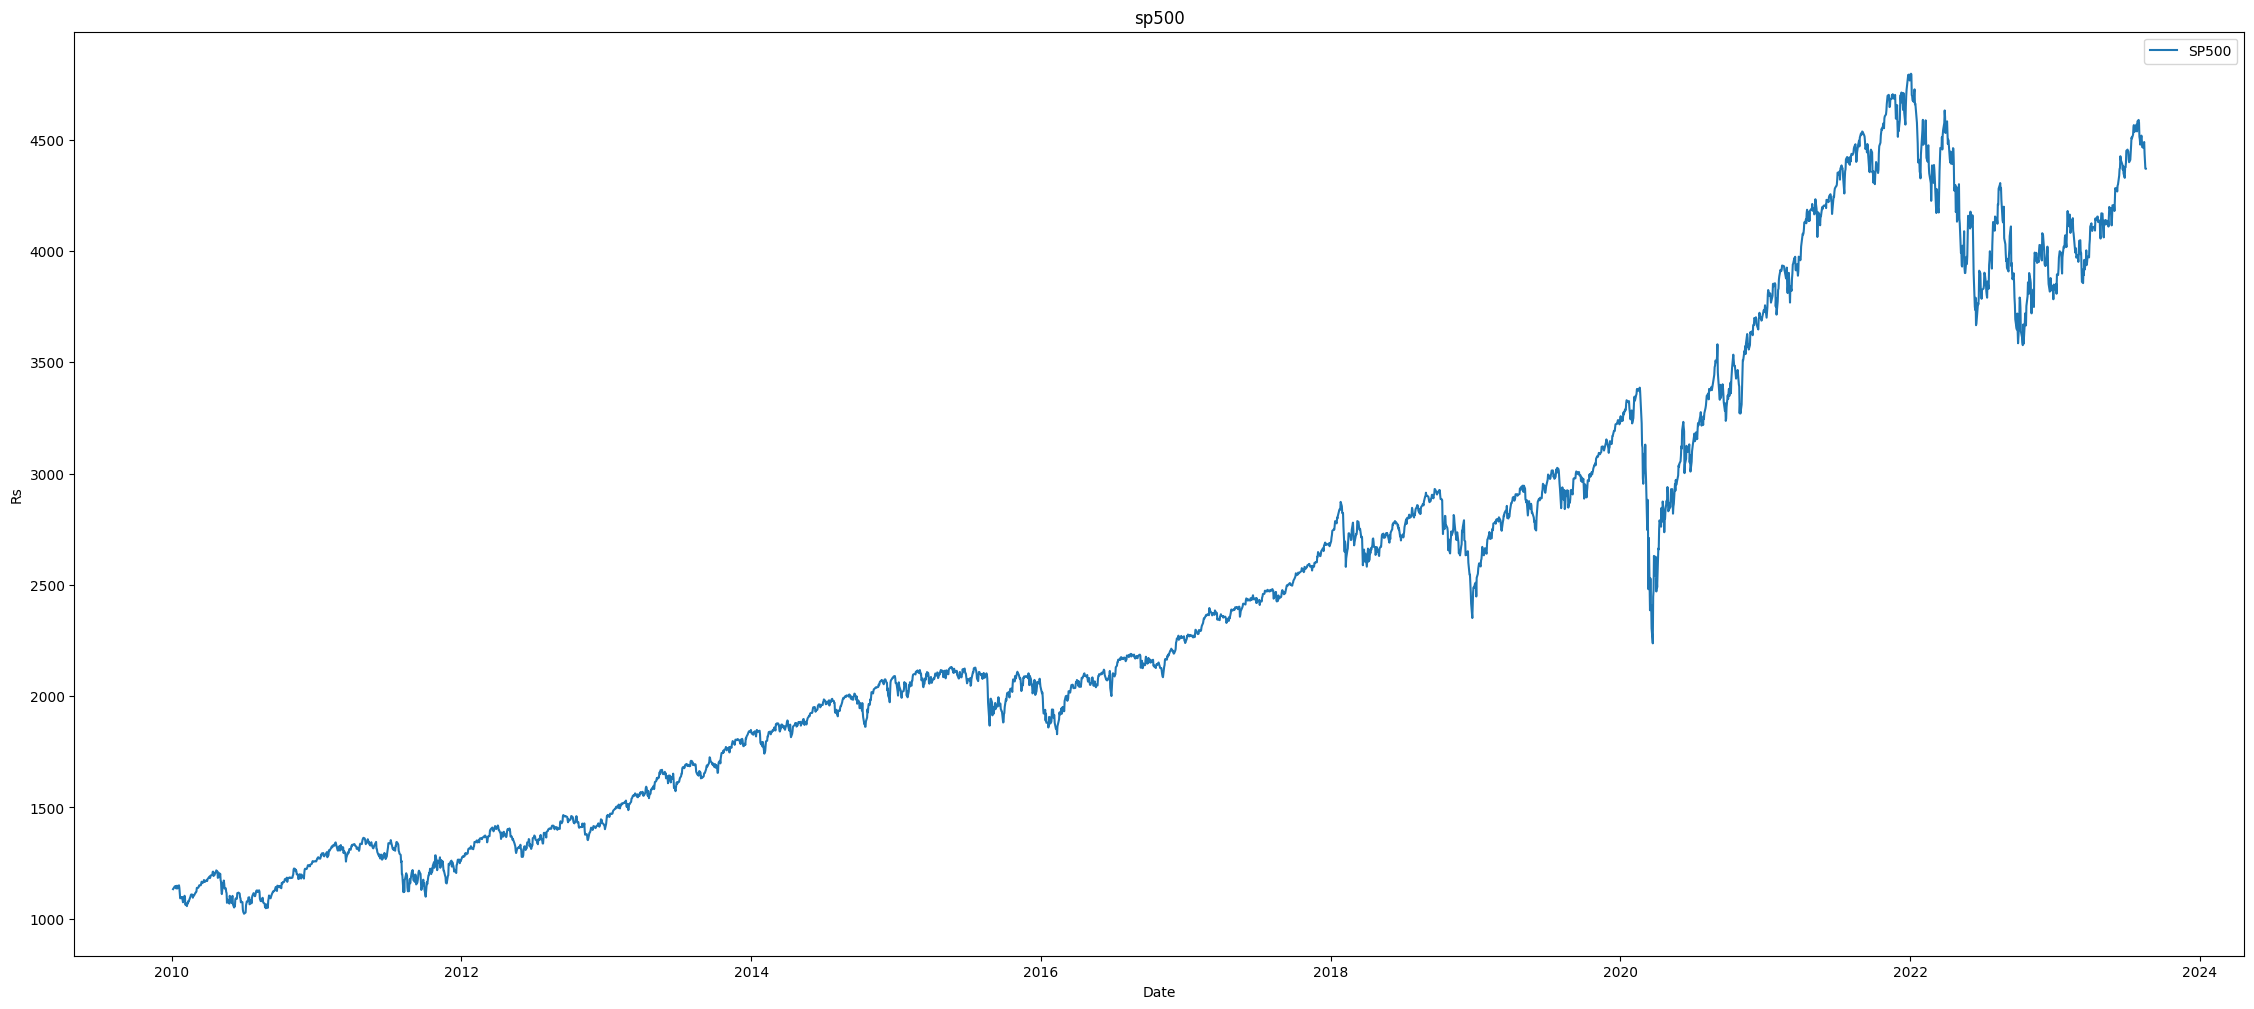

In [89]:
plt.figure(figsize=(28, 12))#, dpi=100)
plt.plot(data.index, data['Adj Close'], label='SP500')
plt.xlabel('Date')
plt.ylabel('Rs')
plt.title('sp500')
plt.legend()
plt.show()

In [90]:
df = data.copy()
df = df.dropna()
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [91]:
print('Total dataset has {} samples, and {} features.'.format(df.shape[0], \
                                                              df.shape[1]))

Total dataset has 3430 samples, and 6 features.


# 2. Feature engineering

In [92]:
FE_df = df

In [93]:
len(FE_df)

3430

# 3. Modèle processing

## 3.1. Data split

In [94]:
data_training = FE_df[FE_df.index < split_date].copy()
data_training.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [95]:
y_train_real_all = data_training["Close"].values.reshape(-1, 1)

In [96]:
#remove the first win_size row which are without prediction
y_train_real = y_train_real_all[win_size:]

In [97]:
data_testing = FE_df[FE_df.index >= split_date].copy()
data_testing.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3179040000
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5015000000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4591020000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6064110000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5099160000


In [98]:
y_test_real = data_testing["Close"].values.reshape(-1, 1)

In [99]:
#scalar = MinMaxScaler()

#data_training_scaled = scalar.fit_transform(data_training)

## 3.2 Data scaling, reshaping, Model

In [100]:
current_datetime = datetime.datetime.today()
formatted_datetime = current_datetime.strftime('%Y-%m-%d %H:%M')

In [101]:
lstm_model, resultat, model_history, scalar,  X_train, y_train, X_test, y_test, y_scaler_train, y_scaler_test = \
LSTM_M0(FE_df, data_training, data_testing, win_size, num_epoch, num_cell, batch_size, dropout)

Epoch 1/150
267/267 [==============================] - ETA: 0s - loss: 0.0046
Epoch 1: val_loss improved from inf to 0.00462, saving model to models/Best\lstm_M0.h5
267/267 [==============================] - 15s 38ms/step - loss: 0.0046 - val_loss: 0.0046
Epoch 2/150
266/267 [============================>.] - ETA: 0s - loss: 0.0010   
Epoch 2: val_loss improved from 0.00462 to 0.00383, saving model to models/Best\lstm_M0.h5
267/267 [==============================] - 9s 35ms/step - loss: 0.0010 - val_loss: 0.0038
Epoch 3/150
265/267 [============================>.] - ETA: 0s - loss: 7.9457e-04
Epoch 3: val_loss improved from 0.00383 to 0.00332, saving model to models/Best\lstm_M0.h5
267/267 [==============================] - 8s 29ms/step - loss: 7.9354e-04 - val_loss: 0.0033
Epoch 4/150
267/267 [==============================] - ETA: 0s - loss: 6.3548e-04
Epoch 4: val_loss improved from 0.00332 to 0.00289, saving model to models/Best\lstm_M0.h5
267/267 [==============================] -

266/267 [============================>.] - ETA: 0s - loss: 2.5935e-04
Epoch 33: val_loss did not improve from 0.00129
267/267 [==============================] - 8s 30ms/step - loss: 2.5994e-04 - val_loss: 0.0014
Epoch 34/150
267/267 [==============================] - ETA: 0s - loss: 2.7270e-04
Epoch 34: val_loss did not improve from 0.00129
267/267 [==============================] - 8s 29ms/step - loss: 2.7270e-04 - val_loss: 0.0013
Epoch 35/150
266/267 [============================>.] - ETA: 0s - loss: 2.6116e-04
Epoch 35: val_loss improved from 0.00129 to 0.00122, saving model to models/Best\lstm_M0.h5
267/267 [==============================] - 8s 29ms/step - loss: 2.6089e-04 - val_loss: 0.0012
Epoch 36/150
265/267 [============================>.] - ETA: 0s - loss: 2.1890e-04
Epoch 36: val_loss did not improve from 0.00122
267/267 [==============================] - 8s 29ms/step - loss: 2.1931e-04 - val_loss: 0.0013
Epoch 37/150
267/267 [==============================] - ETA: 0s - los

267/267 [==============================] - 8s 29ms/step - loss: 2.1516e-04 - val_loss: 0.0013
Epoch 69/150
267/267 [==============================] - ETA: 0s - loss: 2.0273e-04
Epoch 69: val_loss improved from 0.00112 to 0.00111, saving model to models/Best\lstm_M0.h5
267/267 [==============================] - 8s 29ms/step - loss: 2.0273e-04 - val_loss: 0.0011
Epoch 70/150
265/267 [============================>.] - ETA: 0s - loss: 1.8982e-04
Epoch 70: val_loss did not improve from 0.00111
267/267 [==============================] - 8s 29ms/step - loss: 1.8928e-04 - val_loss: 0.0011
Epoch 71/150
265/267 [============================>.] - ETA: 0s - loss: 1.8941e-04
Epoch 71: val_loss did not improve from 0.00111
267/267 [==============================] - 8s 29ms/step - loss: 1.8942e-04 - val_loss: 0.0011
Epoch 72/150
267/267 [==============================] - ETA: 0s - loss: 1.9794e-04
Epoch 72: val_loss improved from 0.00111 to 0.00107, saving model to models/Best\lstm_M0.h5
267/267 [===

Epoch 104/150
265/267 [============================>.] - ETA: 0s - loss: 1.8174e-04
Epoch 104: val_loss did not improve from 0.00105
267/267 [==============================] - 8s 29ms/step - loss: 1.8299e-04 - val_loss: 0.0011
Epoch 105/150
267/267 [==============================] - ETA: 0s - loss: 2.3901e-04
Epoch 105: val_loss did not improve from 0.00105
267/267 [==============================] - 8s 29ms/step - loss: 2.3901e-04 - val_loss: 0.0011
Epoch 106/150
266/267 [============================>.] - ETA: 0s - loss: 1.9151e-04
Epoch 106: val_loss did not improve from 0.00105
267/267 [==============================] - 8s 28ms/step - loss: 1.9177e-04 - val_loss: 0.0011
Epoch 107/150
267/267 [==============================] - ETA: 0s - loss: 1.8683e-04
Epoch 107: val_loss did not improve from 0.00105
267/267 [==============================] - 8s 29ms/step - loss: 1.8683e-04 - val_loss: 0.0011
Epoch 108/150
266/267 [============================>.] - ETA: 0s - loss: 1.9354e-04
Epoch 10

In [102]:
resultat.insert(0, formatted_datetime)

# 4. Evaluation performance

## 4.1. Scaled performance

In [103]:
def lstm_scaled_perfomance(model_history, start_epoch=1):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(start_epoch, start_epoch + len(model_history.history['loss']))
    
    # loss, val_loss 
    axs[0].plot(epochs, model_history.history['loss'], label='Training Loss')
    axs[0].plot(epochs, model_history.history['val_loss'],  label='Validation Loss')
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validation'], loc='best')
    
    # transforme MSE en RMSE
    loss_history = pd.DataFrame(model_history.history).pow(.5)
    loss_history.index += 1    
#calcule la valeur minimale de la colonne val_loss dans le DataFrame loss_history, 
#ce qui correspond au meilleur RMSE de validation atteint par le modèle.
    best_rmse = loss_history.val_loss.min()
    best_epoch = loss_history.val_loss.idxmin()    
    title = f'Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
    loss_history.columns=['Training RMSE', 'Validation RMSE']
    
    loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=axs[1])    
    axs[1].axvline(best_epoch, ls='--', lw=1, c='k')
    
    sns.despine()
    fig.tight_layout()    
    plt.show()
    return best_rmse, best_epoch

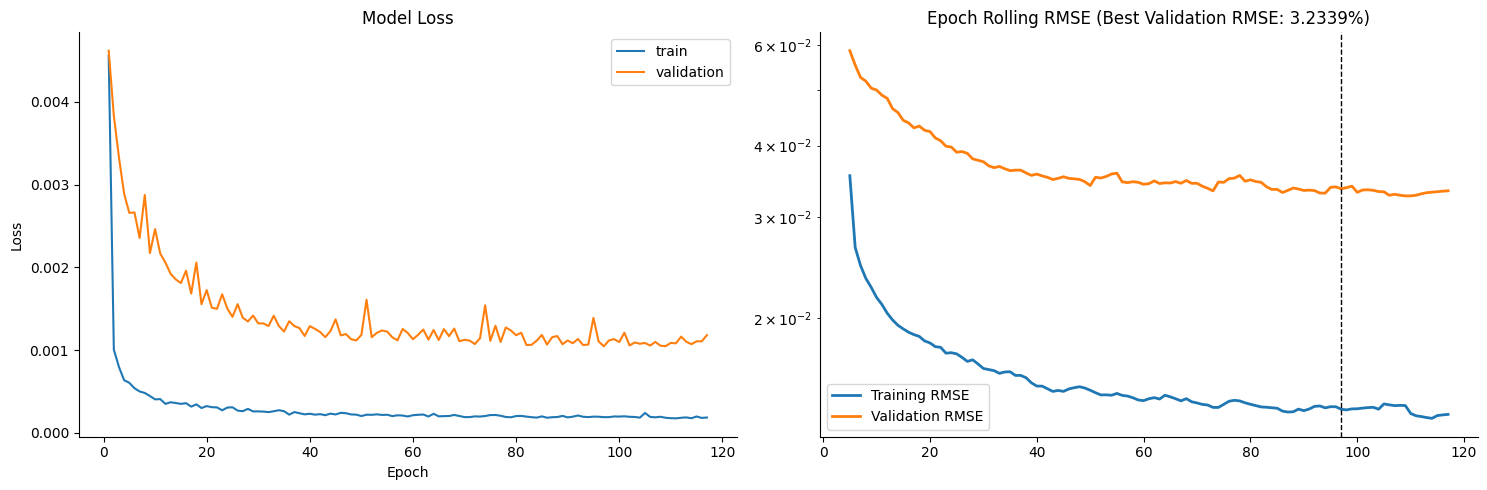

In [104]:
best_rmse, best_epoch = lstm_scaled_perfomance(model_history)

In [105]:
y_train_predict_scaled = lstm_model.predict(X_train)
y_test_predict_scaled = lstm_model.predict(X_test)

21/21 [==============================] - 3s 15ms/step


In [106]:
from scipy.stats import spearmanr
train_ic = spearmanr(y_train, y_train_predict_scaled)[0]
test_ic = spearmanr(y_test, y_test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9990 | Test IC: 0.9830


In [107]:
resultat.extend([round(train_ic, 4), round(test_ic,4)])

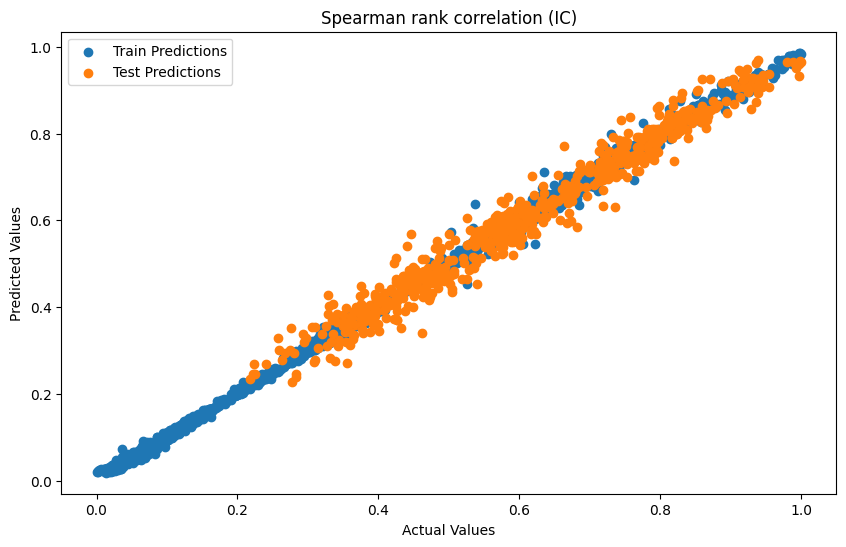

In [108]:
import matplotlib.pyplot as plt

# Plotting the train and test predictions against actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_predict_scaled, label='Train Predictions')
plt.scatter(y_test, y_test_predict_scaled, label='Test Predictions')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Spearman rank correlation (IC)')
plt.legend()
plt.show()

## 4.2. Rescaled performance

In [109]:
def lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    axs[0].plot(y_train_real, color = 'red', label = 'Real SP500 Price')
    axs[0].plot(y_train_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[0].set_title('SP500 Train Price Prediction')
    axs[0].set_ylabel('Price')
    axs[0].set_xlabel('Time')
    axs[0].legend(['Real', 'Predict'], loc='best')

    axs[1].plot(y_test_real, color = 'red', label = 'Real SP500 Price')
    axs[1].plot(y_test_predict, color = 'blue', label = 'Predicted SP500 Price')
    axs[1].set_title('SP500 Test Price Prediction')
    axs[1].set_ylabel('Price')
    axs[1].set_xlabel('Time')
    axs[1].legend(['Real', 'Predict'], loc='best')

    plt.legend()  
    plt.show()
    return

In [110]:
y_test_predict = y_scaler_test.inverse_transform(y_test_predict_scaled)
y_train_predict = y_scaler_train.inverse_transform(y_train_predict_scaled)

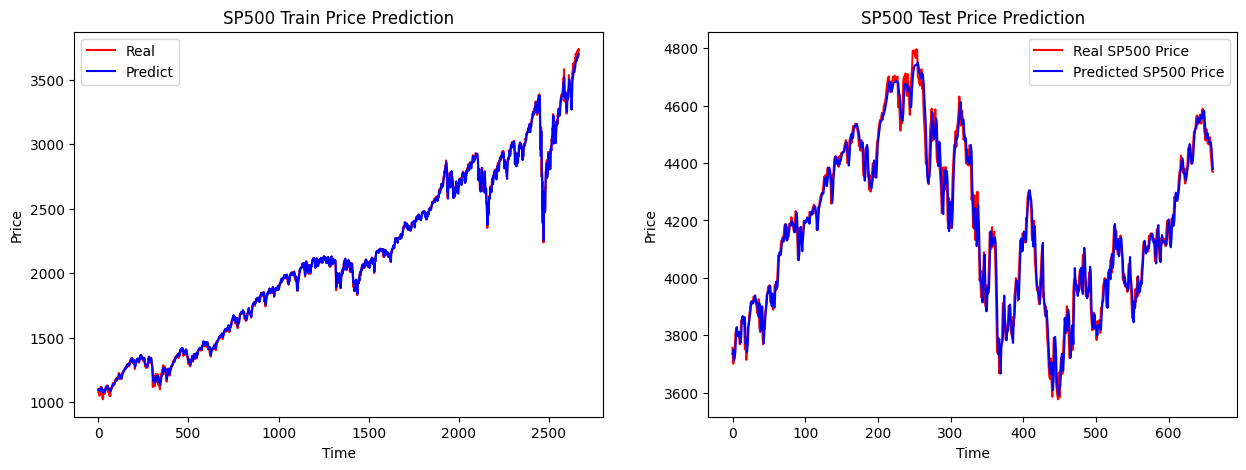

In [111]:
lstm_real_predict(y_train_real, y_train_predict, y_test_real, y_test_predict)

In [112]:
train_rmse_scaled = np.sqrt(lstm_model.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(lstm_model.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0096 | Test RMSE: 0.0323


In [113]:
resultat.extend([round(train_rmse_scaled, 4), round(test_rmse_scaled,4)])

In [114]:
train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train_real))
test_rmse = np.sqrt(mean_squared_error(y_test_predict, y_test_real))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 25.94 | Test RMSE: 50.44'

In [115]:
resultat.extend([round(train_rmse, 2), round(test_rmse,2)])

In [121]:
models_performance = pd.read_csv('models_performance.csv', index_col=[0])
models_performance.loc[len(models_performance)] = resultat
models_performance.to_csv('models_performance.csv')

In [128]:
models_performance.head()

,Date,Modele,win_size,num_cell,num_epoch,batch_size,dropout,rsme,train_duration(s),IC_train,IC_test,rmse_train-scale,rmse_test_scale,rmse_train,rmse_test
0,2023-08-19 22:04,M0,60,50,100,64,0.5,0.0488,43.0,0.9975,0.965,0.0170,0.0488,46.25,74.47
1,2023-08-19 22:13,M0,100,100,150,10,0.2,0.0323,917.0,0.9990,0.983,0.0096,0.0323,25.94,50.44
